1 body
2 brain
3 left_lung
4 right_lung
5 heart
6 left_kidney
7 right_kidney
8 liver


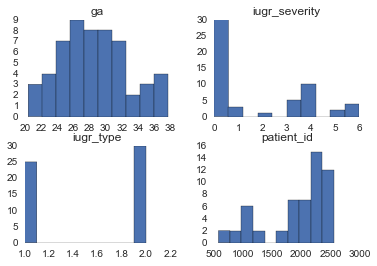

In [3]:
%matplotlib inline

import irtk
import numpy as np
from glob import glob
import os
import scipy.ndimage as nd

import matplotlib
#matplotlib.use('cairo')
import matplotlib.pyplot as plt

import cPickle as pk

import csv

# http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.cluster import MeanShift, KMeans

from joblib import Parallel, delayed

import base64
import skimage.io
from copy import deepcopy

from IPython.display import display

hastie_orange = (0.906,0.624,0)
hastie_blue = (0.337,0.706,0.914)
hastie_red = (0.678,0.137,0.137)
hastie_green = (0.114,0.412,0.078)

ground_truth_labels = [ "body",
                        "brain",
                        "left_lung",
                        "right_lung",
                        "heart",
                        "left_kidney",
                        "right_kidney",
                        "liver" ]

for i in range(len(ground_truth_labels)):
    print i+1, ground_truth_labels[i]
    
all_ga = {}
reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/melissa_ga.tsv", "rb"), delimiter="\t" )
for patient_id, ga in reader:
    all_ga[patient_id] = float(ga)
    
all_iugr = {}
reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/iugr.tsv", "rb"), delimiter="\t" )
skip = True
for patient_id, iugr, iugr_severity in reader:
    if skip:
        skip = False
        continue
    all_iugr[patient_id] = (int(iugr), int(iugr_severity))
  
all_subjects = []
all_files = glob("/vol/vipdata/data/fetal_data/Mellisa_Damodaram/full_body_segmentations/*_seg.nii.gz")
for f in all_files:
    patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
    all_subjects.append( [ int(patient_id),
                           all_ga[patient_id],
                           all_iugr[patient_id][0],
                           all_iugr[patient_id][1] ])
    
all_subjects = np.array(all_subjects)
all_subjects = pd.DataFrame( dict( patient_id=all_subjects[:,0],
                                   ga=all_subjects[:,1],
                                   iugr_type=all_subjects[:,2],
                                   iugr_severity=all_subjects[:,3]))

all_subjects.hist();

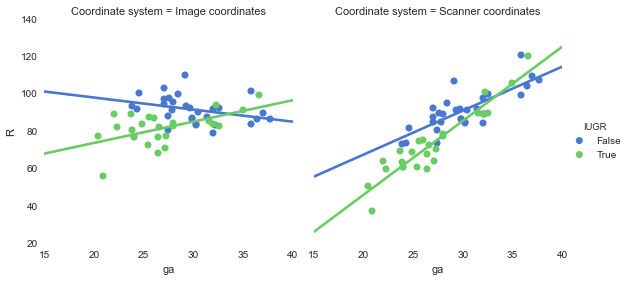

In [4]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        # Scanner coordinates
        brain_center_world = labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')[::-1])

        heart_center_world =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')[::-1])
        
        v_world = heart_center_world - brain_center_world
        R_world = np.linalg.norm(v_world)
        
        res.loc[2*i] = [patient_id, ga, R_world, all_iugr[patient_id][0]==1, 'Scanner coordinates']
        
        # Image coordinates
        brain_center = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')

        heart_center = np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')

        v = heart_center - brain_center
        R = np.linalg.norm(v)
        
        res.loc[2*i+1] = [patient_id, ga, R, all_iugr[patient_id][0]==1, 'Image coordinates']

    return res

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/data_resampled")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

pk.dump(res,open('data_size_normalisation.pk', 'wb'))

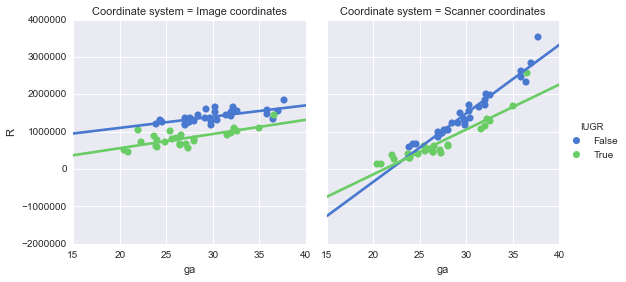

In [28]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        volume = float(np.sum(labels>0))
        res.loc[2*i] = [patient_id, ga, volume, all_iugr[patient_id][0]==1, 'Image coordinates']
        
        # Scanner coordinates
        volume_scanner = float(volume*labels.header['pixelSize'][0]*labels.header['pixelSize'][1]*labels.header['pixelSize'][2])
        
        res.loc[2*i+1] = [patient_id, ga, volume_scanner, all_iugr[patient_id][0]==1, 'Scanner coordinates']

    return res.convert_objects(convert_numeric=True)

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

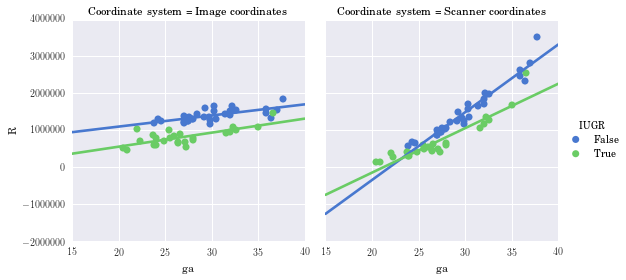

In [2]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        volume = float(np.sum(labels>0))
        res.loc[2*i] = [patient_id, ga, volume, all_iugr[patient_id][0]==1, 'Image coordinates']
        
        # Scanner coordinates
        volume_scanner = float(volume*labels.header['pixelSize'][0]*labels.header['pixelSize'][1]*labels.header['pixelSize'][2])
        
        res.loc[2*i+1] = [patient_id, ga, volume_scanner, all_iugr[patient_id][0]==1, 'Scanner coordinates']

    return res.convert_objects(convert_numeric=True)

plt.rc('text', usetex=True, color='black')
plt.rc('font', family='serif')

fig = plt.figure(figsize=(10, 5))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center")

sns.regplot
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.6980392156862745), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


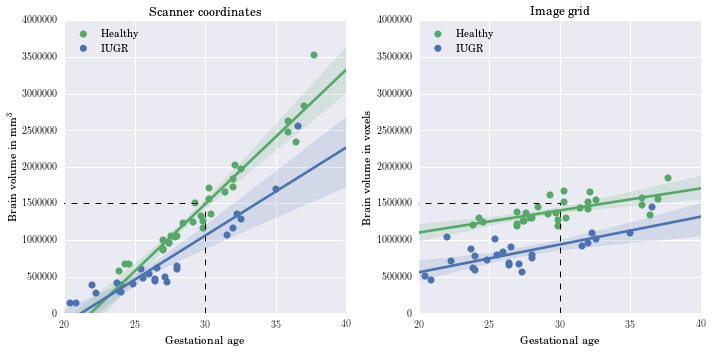

In [54]:
plt.rc('text', usetex=True, color='black')
plt.rc('font', family='serif')

palette = sns.color_palette("deep")

fig = plt.figure(figsize=(10, 5))
#gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax2 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot
ax1.plot((30, 30), (0, 1500000), 'k--', linewidth=1);
ax2.plot((30, 30), (0, 1500000), 'k--', linewidth=1);

ax1.plot((0, 30), (1500000, 1500000), 'k--', linewidth=1);
ax2.plot((0, 30), (1500000, 1500000), 'k--', linewidth=1);

sns.regplot("ga", "R", data=res[np.logical_and(res['Coordinate system']=='Image coordinates',
                                                           res['IUGR']==0)],
           scatter_kws={"s": 50, "alpha": 1}, ax=ax1,color=palette[1],label='Healthy');
sns.regplot("ga", "R", data=res[np.logical_and(res['Coordinate system']=='Image coordinates',
                                                           res['IUGR']==1)],
           scatter_kws={"s": 50, "alpha": 1}, ax=ax1,color=palette[0],label='IUGR');

ax1.set_xlim([20,40]);
ax1.set_ylim([0,4000000]);

obj = ax1.set_ylabel("Brain volume in voxels")
plt.setp(obj, color='black')
obj = ax1.set_xlabel(r"Gestational age")
plt.setp(obj, color='black')
obj = ax1.set_title('Image grid');
plt.setp(obj, color='black')

axes_obj = plt.getp(ax1,'axes')                 #get the axes' property handler
ytl_obj = plt.getp(axes_obj, 'yticklabels')     #get the properties for 
                                                #  yticklabels
plt.setp(ytl_obj, color='black')


# http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.regplot.html#seaborn.regplot
sns.regplot("ga", "R", data=res[np.logical_and(res['Coordinate system']=='Scanner coordinates',
                                                           res['IUGR']==0)],
           scatter_kws={"s": 50, "alpha": 1}, ax=ax2,color=palette[1],label='Healthy');
sns.regplot("ga", "R", data=res[np.logical_and(res['Coordinate system']=='Scanner coordinates',
                                                           res['IUGR']==1)],
           scatter_kws={"s": 50, "alpha": 1}, ax=ax2,color=palette[0],label='IUGR');

print sns.color_palette()

ax2.set_xlim([20,40]);
ax2.set_ylim([0,4000000]);

obj = ax2.set_ylabel(r"Brain volume in mm\textsuperscript{3}")
plt.setp(obj, color='black')
obj = ax2.set_xlabel(r"Gestational age")
plt.setp(obj, color='black')
obj = ax2.set_title('Scanner coordinates');
plt.setp(obj, color='black')

axes_obj = plt.getp(ax2,'axes')                 #get the axes' property handler
ytl_obj = plt.getp(axes_obj, 'yticklabels')     #get the properties for 
                                                #  yticklabels
plt.setp(ytl_obj, color='black')

legend = ax1.legend(loc='upper left')
legend = ax2.legend(loc='upper left')

fig.tight_layout()

plt.savefig("brain_volume_normalisation.pdf", bbox_inches="tight");

In [2]:
class SKImage(skimage.io.Image):
    """
    http://nbviewer.ipython.org/urls/gist.github.com/stefanv/6416926/raw/96978d6ad6991c26ccce995327b1adb6aceeeb6e/side_by_side.ipynb
    """
    def __init__(self, *args, **kwargs):
        self._width = kwargs.pop('width', '100%')
        skimage.io.Image.__init__(self, *args, **kwargs)
    def _repr_html_(self):
        out = '<img width="%s"' % self._width
        out += ' src="data:image/png;base64,' + \
               base64.b64encode(np.compat.asbytes(self._repr_png_())) + '"/>'
        return out

class MyTable(object):
    def __init__(self, folder,width=100):
        self.folder = folder
        self.width = width

    def _repr_html_(self):
        all_files = sorted(glob( self.folder+"/*" ))
        s = "<div style='float: left;'>"
        s+= "<table style='width:"+str(self.width)+"%'>"
        for i in range(0,len(all_files)/2,2):
            c1 = self.color(all_files[2*i])
            f1 = 'file://'+os.path.abspath(all_files[2*i])
            if 2*i+1 < len(all_files): #(len(all_files) % 2) == 1:
                f2 = os.path.abspath(all_files[2*i+1])
                c2 = self.color(all_files[2*i+1])
            else:
                f2 = None
            s +=  "<tr><td bgcolor="+c1+">"+SKImage(skimage.io.imread(f1))._repr_html_()+"</td>"
            if f2 is not None:
                s +=  "<td bgcolor="+c2+">"+SKImage(skimage.io.imread(f2))._repr_html_()+"</td>"
            s += "</tr>"
            
        s += "</table></div>"
        
        return s
    
    def color(self,f):
        patient_id = os.path.basename(f)[:-len(".png")]
        if all_iugr[patient_id][0] == 1:
            return '"#FF0000"' # red
        else:
            return '"#00FF00"' # green

In [2]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/heart_center/*_img.nii.gz" ))
print "total files:", len(all_files)

if not os.path.exists('tmp/heart_png'):
    os.makedirs('tmp/heart_png')
    
header = irtk.imread(all_files[0]).get_header()
    
average = irtk.zeros(deepcopy(header))
average1 = irtk.zeros(deepcopy(header))
average2 = irtk.zeros(deepcopy(header))

header['dim'][3] = 8
proba = irtk.zeros(deepcopy(header),dtype='float32')

all_data = []

n1 = 0
n2 = 0
for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32').rescale(0,1000)
    irtk.imshow(img,filename="tmp/heart_png/"+patient_id+".png") # index is ZYX
    average += img
    if all_iugr[patient_id][0]==1:
        average1 += img
        n1 += 1
    else:
        average2 += img
        all_data.append(img)
        n2 += 1
        
        seg = irtk.imread("/vol/bitbucket/kpk09/detector/heart_center/"+patient_id+"_seg.nii.gz")
        for l in range(8):
            proba[l] += (seg == (l+1)).astype("float32")
        
        
print n1,n2
        
average /= len(all_files)
average1 /= n1
average2 /= n2 

proba /= n2 #len(all_files)

irtk.imwrite("tmp/average_heart_center.nii.gz",average);
irtk.imwrite("tmp/average1_heart_center.nii.gz",average1);
irtk.imwrite("tmp/average2_heart_center.nii.gz",average2);

irtk.imwrite("tmp/proba_heart_center.nii.gz",proba);

all_data = np.array(all_data)
median = irtk.Image( np.median(all_data,axis=0), average.get_header() )
irtk.imwrite("tmp/median2_heart_center.nii.gz",median);

total files: 55
25 30



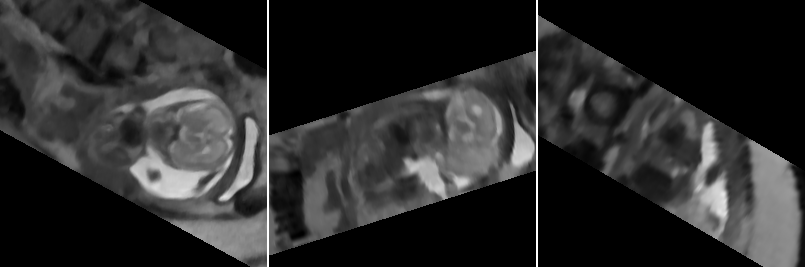
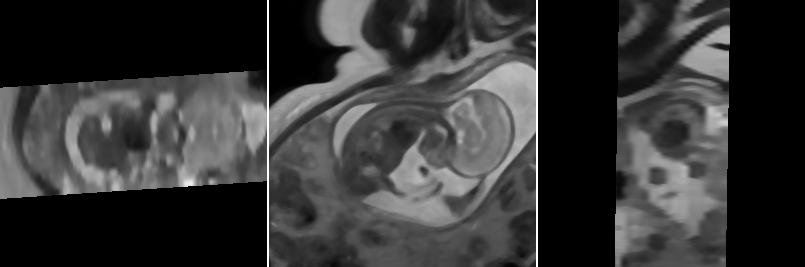
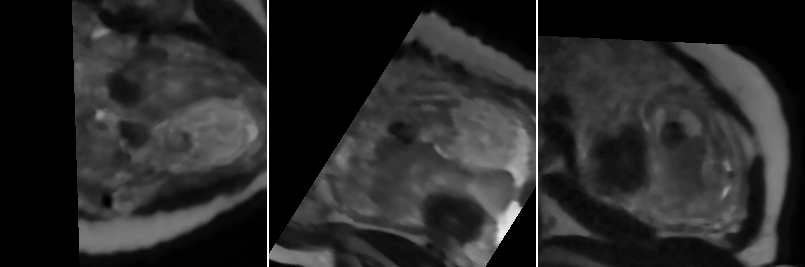
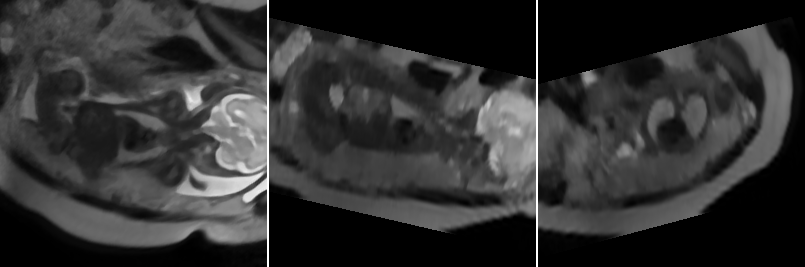
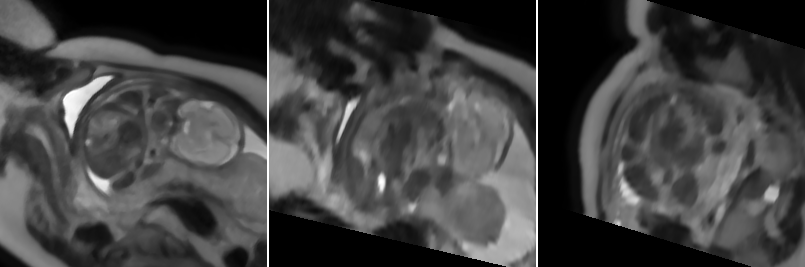
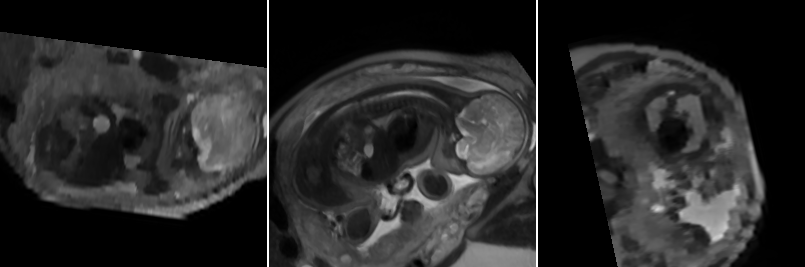
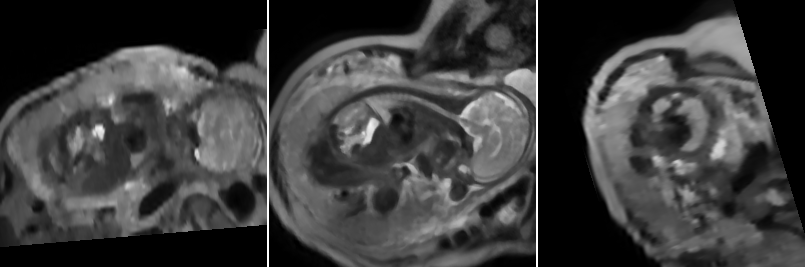
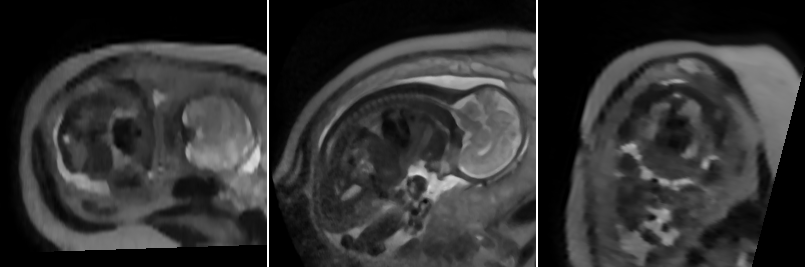
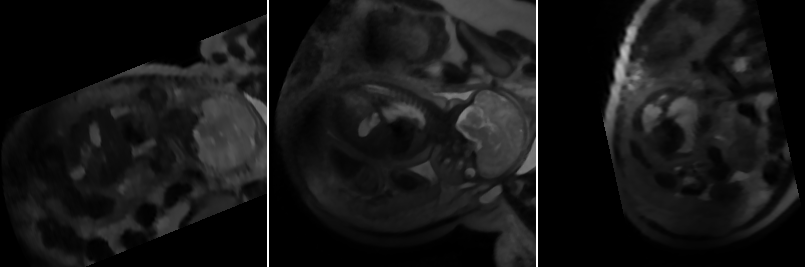
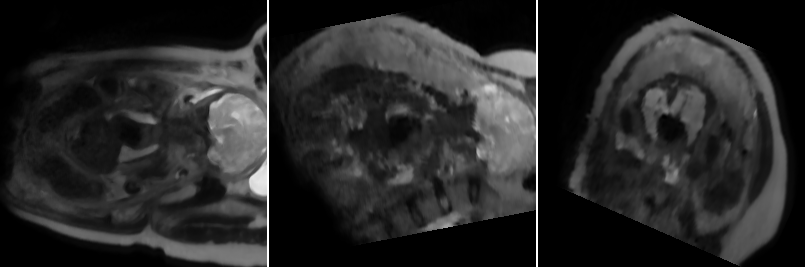
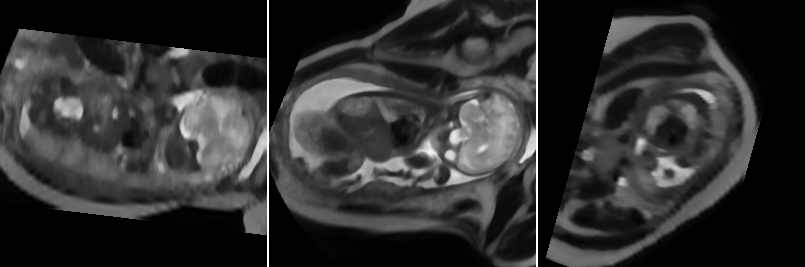
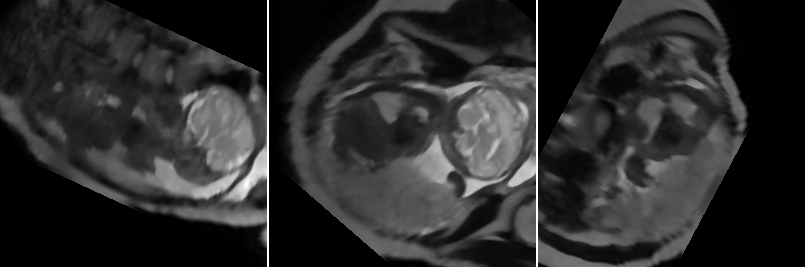
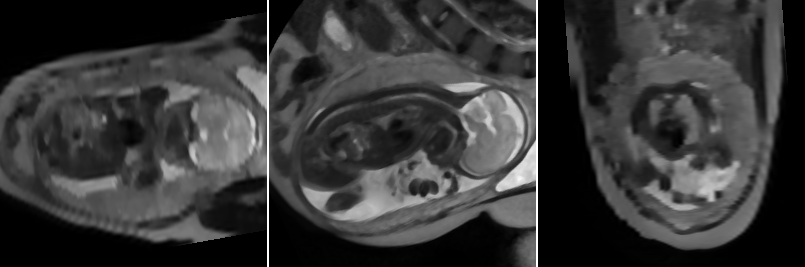
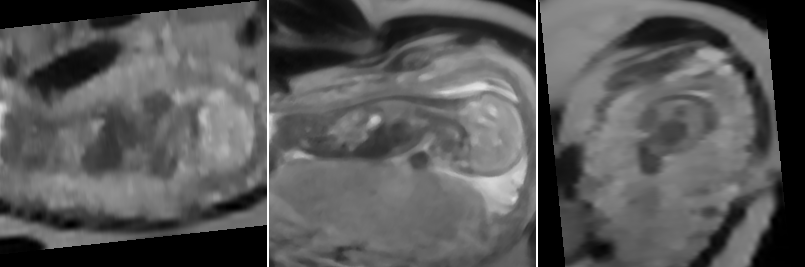
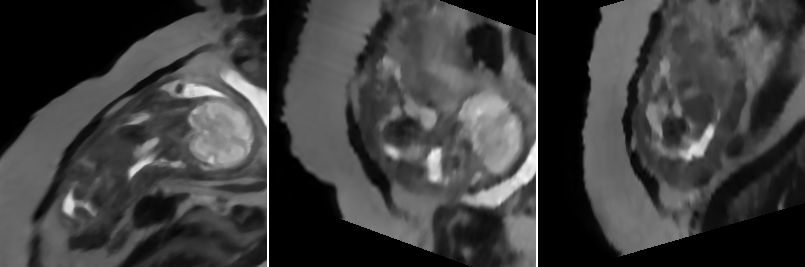
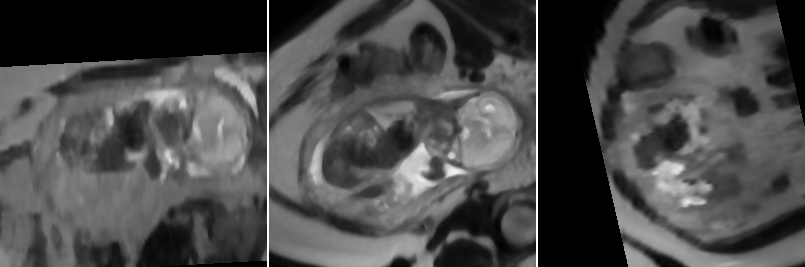
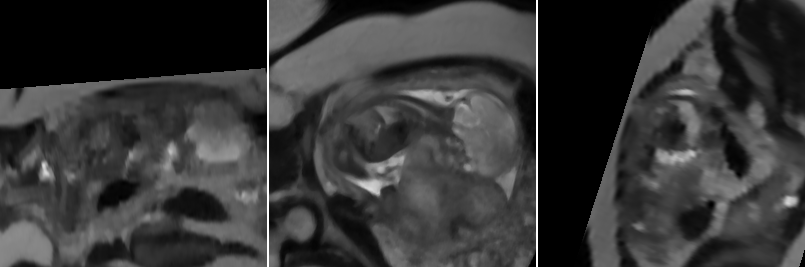
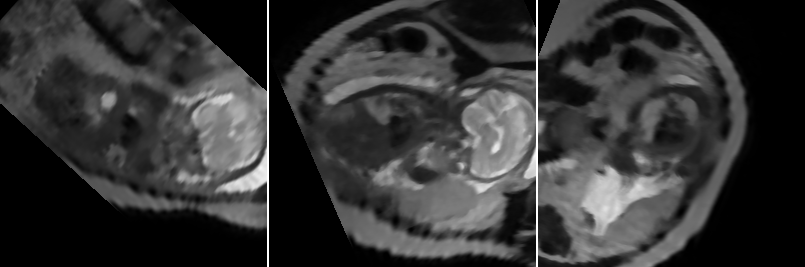
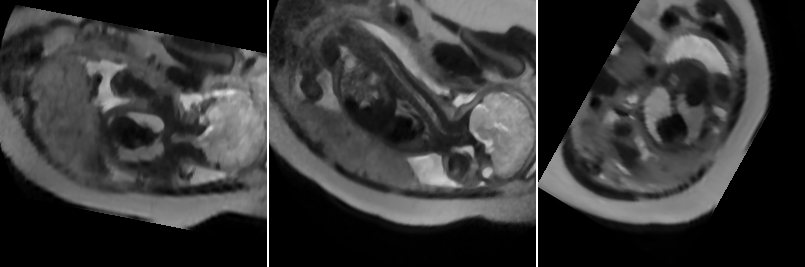
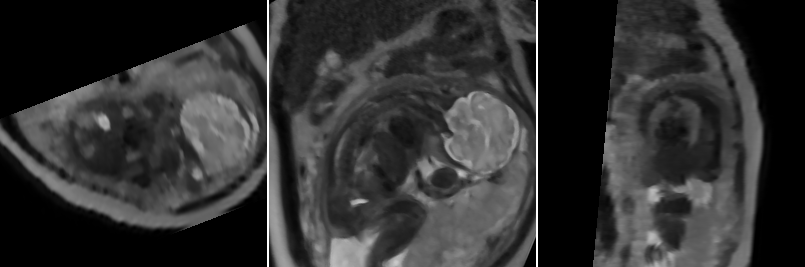
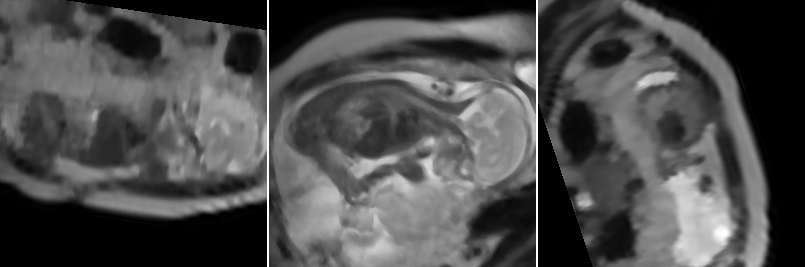
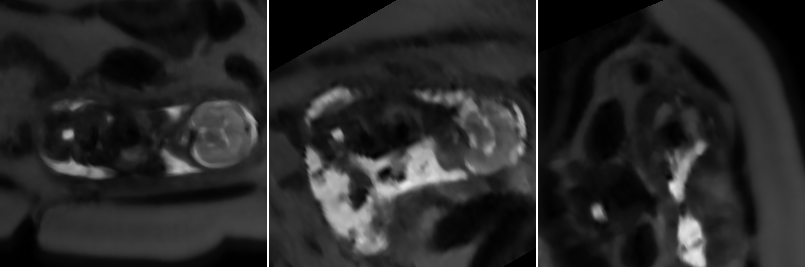
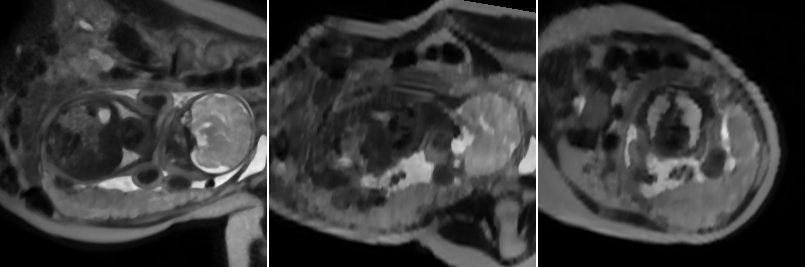
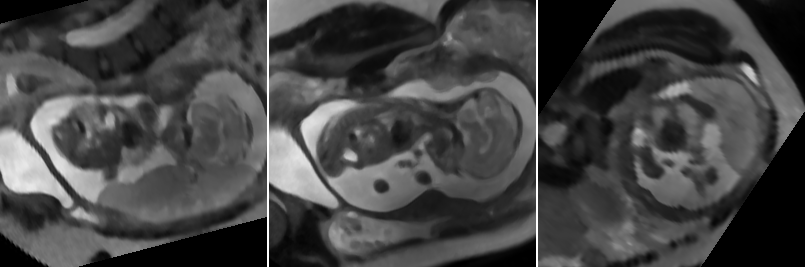
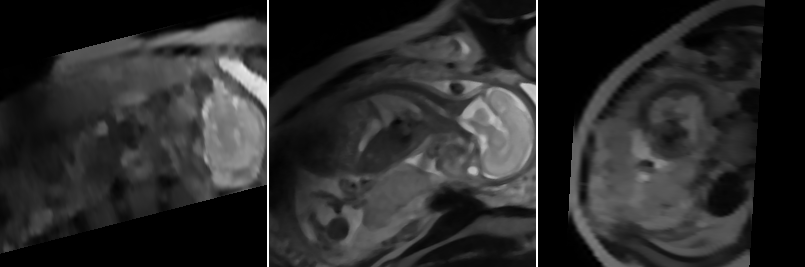
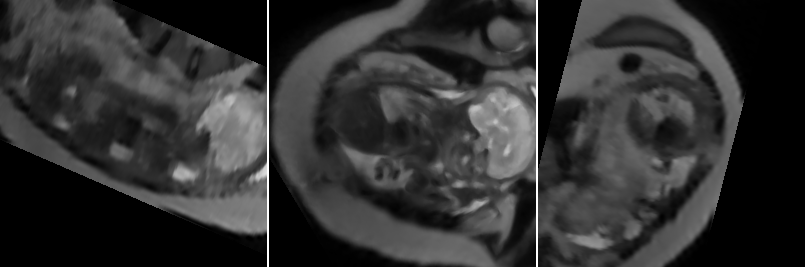
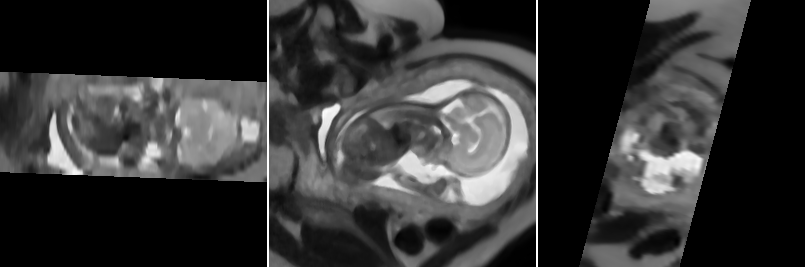
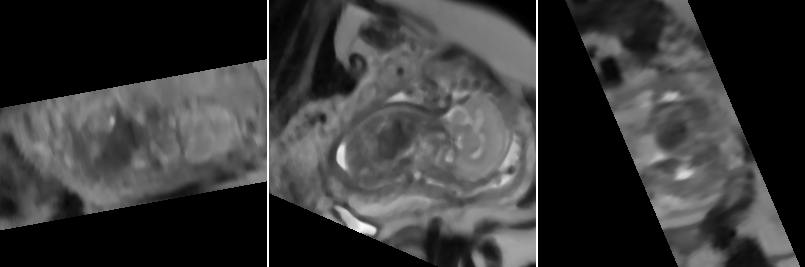

In [3]:
MyTable("tmp/heart_png",width=80)

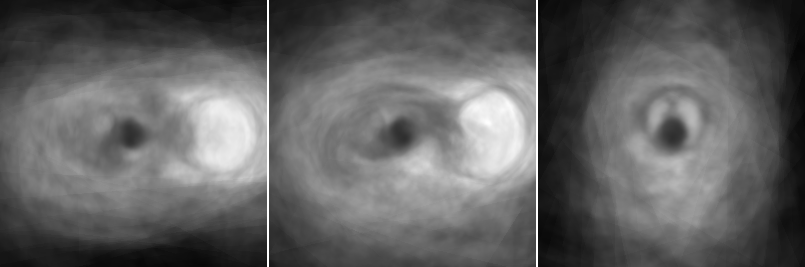

In [11]:
irtk.imshow(irtk.imread("tmp/average_heart_center.nii.gz"))

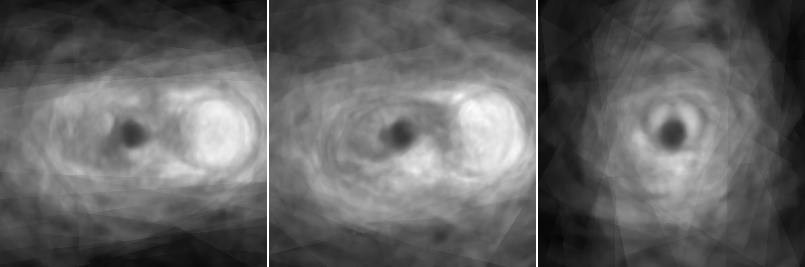

In [12]:
# average of all IUGR fetuses
irtk.imshow(irtk.imread("tmp/average1_heart_center.nii.gz"))

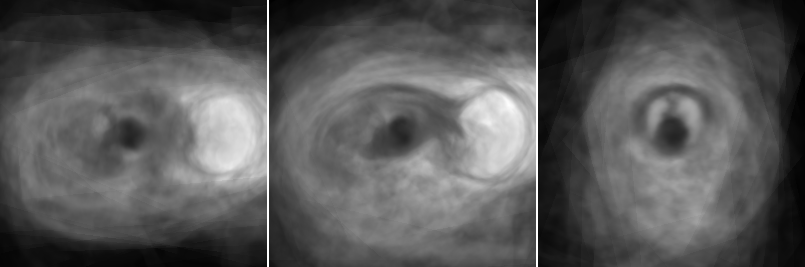

In [13]:
# average of all healthy fetuses
irtk.imshow(irtk.imread("tmp/average2_heart_center.nii.gz"))

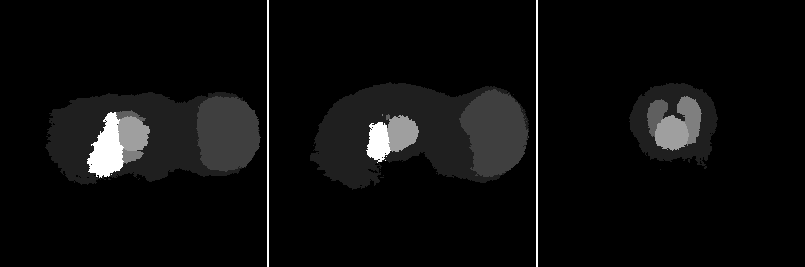

In [9]:
proba = irtk.imread("tmp/proba_heart_center.nii.gz")
background = 1.0 - proba.sum(axis=0)
proba = np.concatenate((background[np.newaxis,...],proba),axis=0)
seg = np.argmax(proba,axis=0)
irtk.imwrite("tmp/seg_template.nii.gz", irtk.Image( seg ) )
irtk.imshow(irtk.Image(seg))

In [6]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/brain_center/*_img.nii.gz" ))
print "total files:", len(all_files)

if not os.path.exists('tmp/brain_png'):
    os.makedirs('tmp/brain_png')
    
average = irtk.zeros(irtk.imread(all_files[0]).get_header())

for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32').rescale(0,1000)
    irtk.imshow(img,filename="tmp/brain_png/"+patient_id+".png") # index is ZYX
    average += img
       
average /= len(all_files)

irtk.imwrite("tmp/average_brain_center.nii.gz",average);

total files: 55



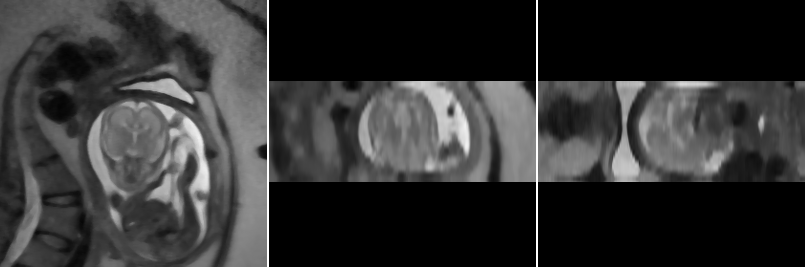
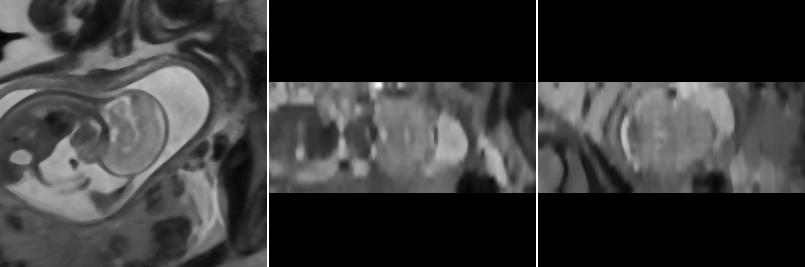
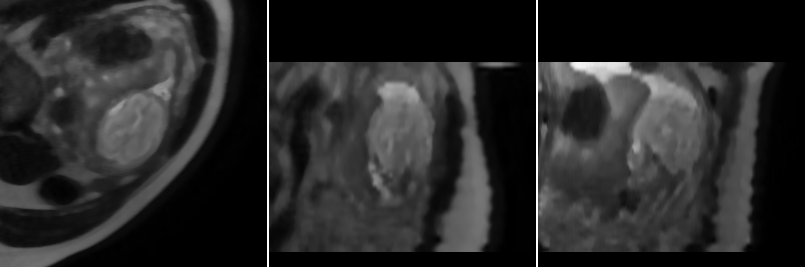
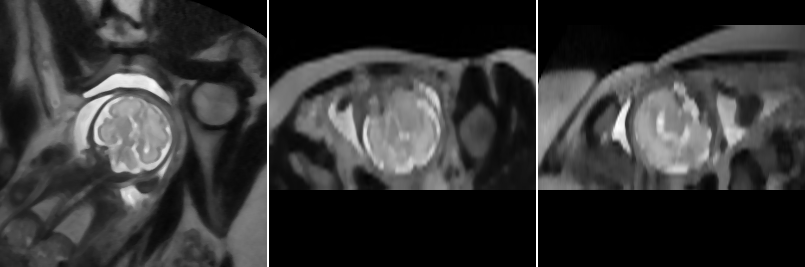
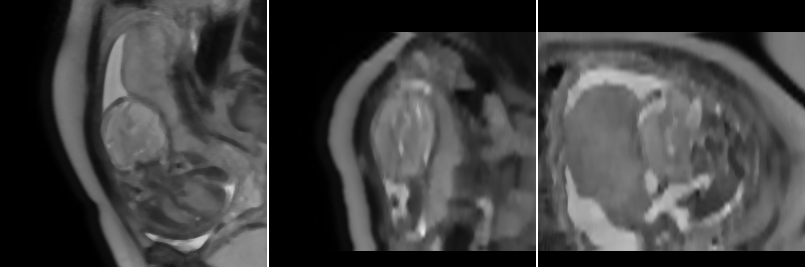
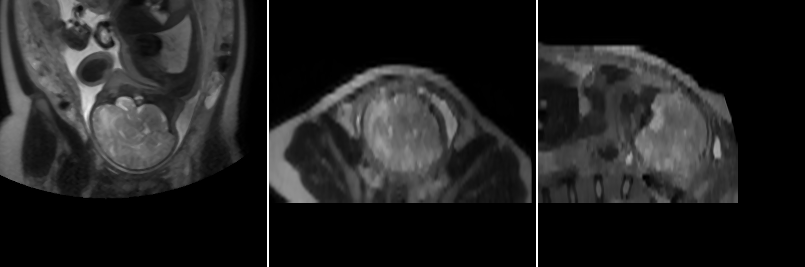
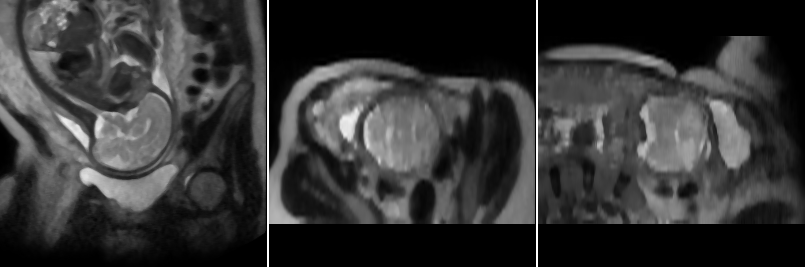
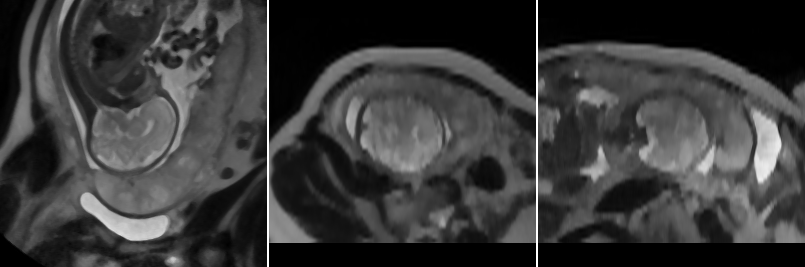
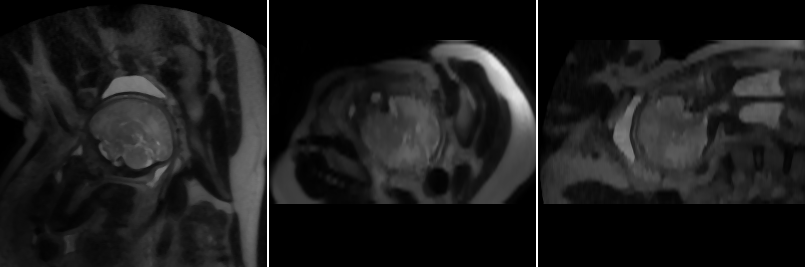
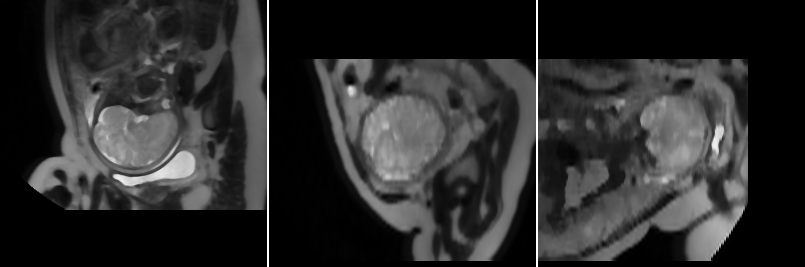
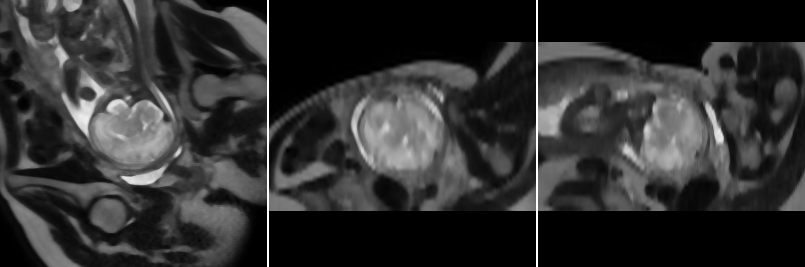
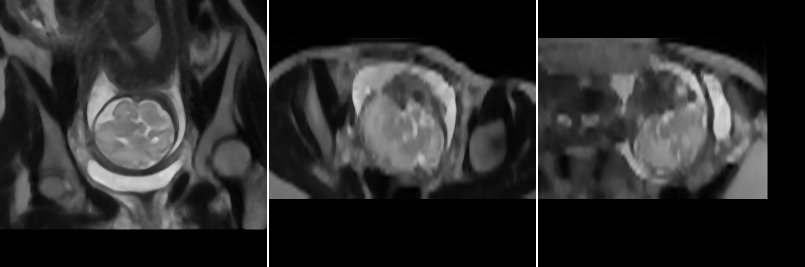
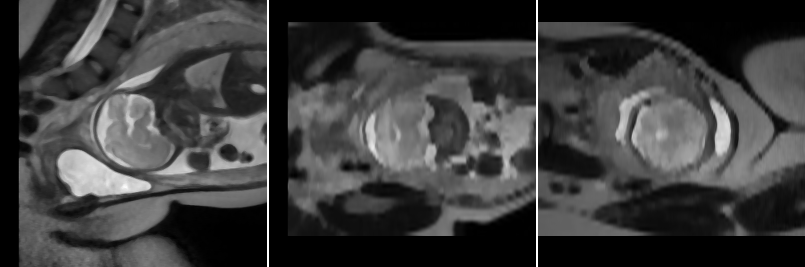
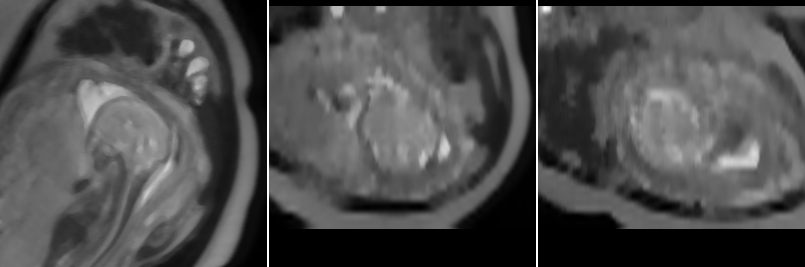
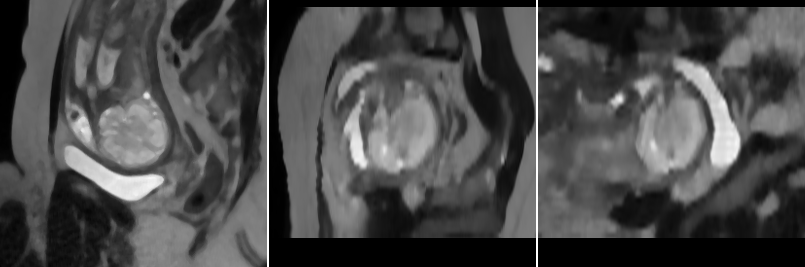
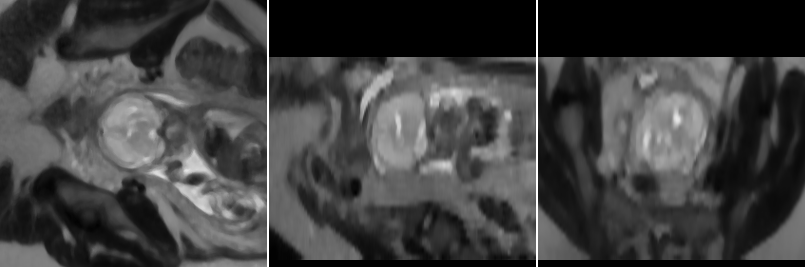
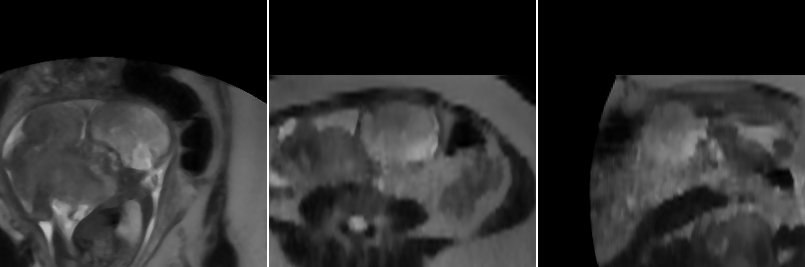
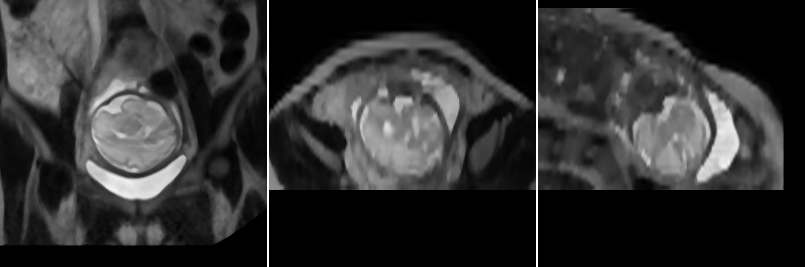
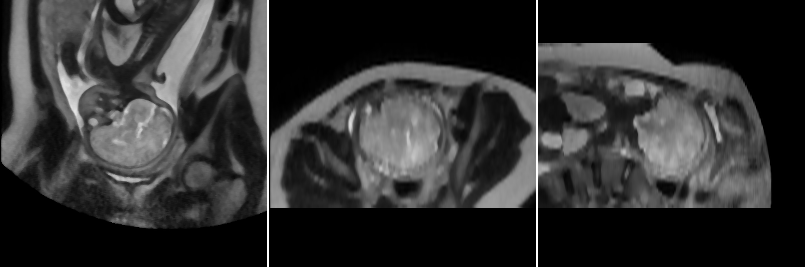
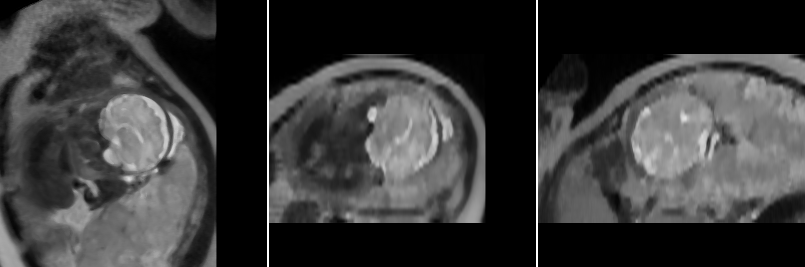
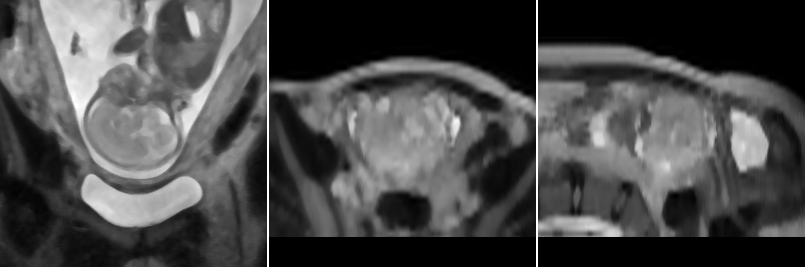
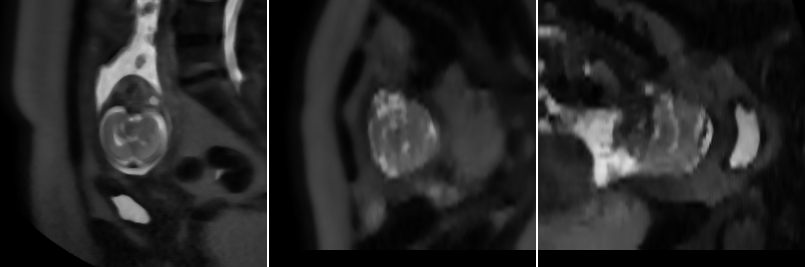
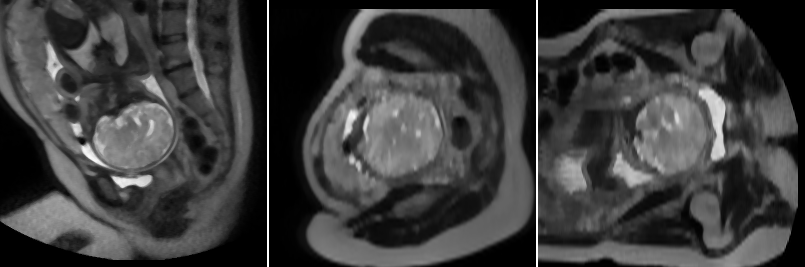
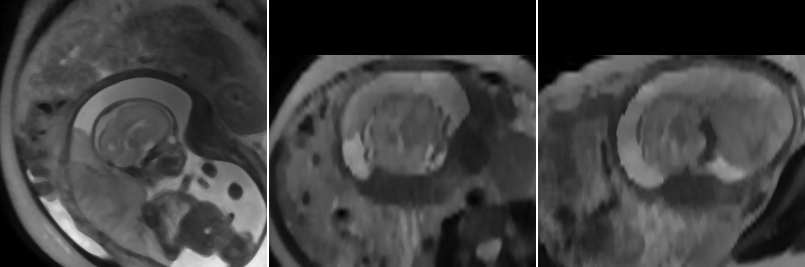
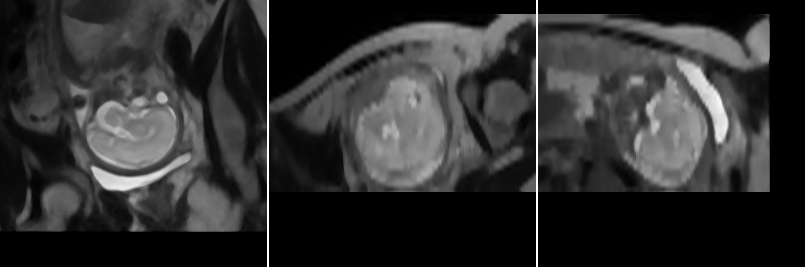
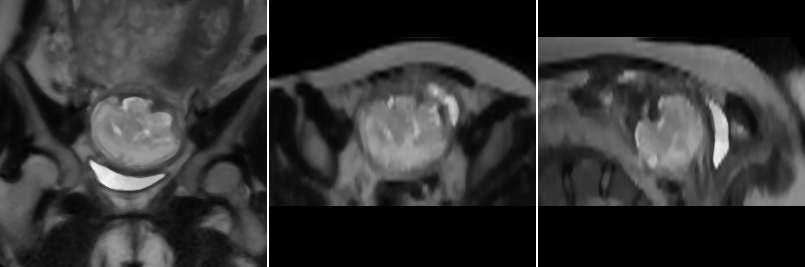
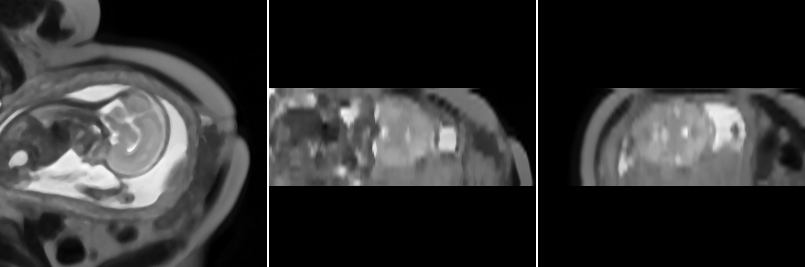
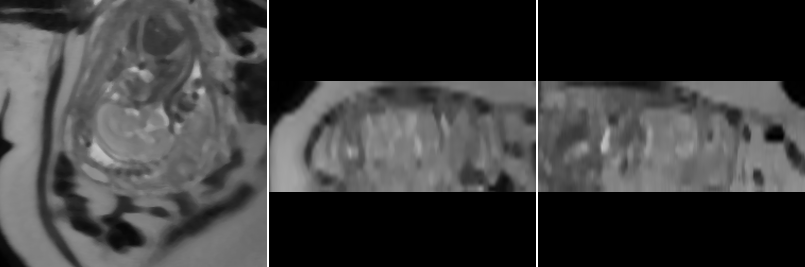

In [4]:
MyTable("tmp/brain_png",width=80)

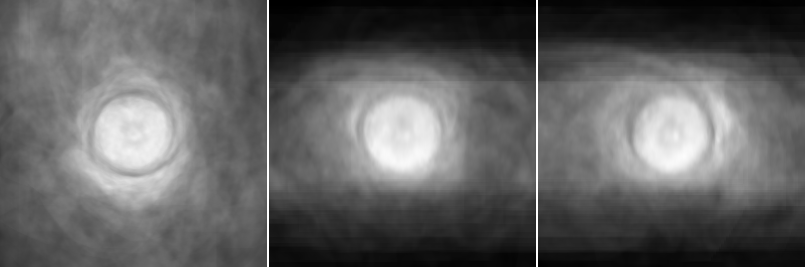

In [14]:
# average of all fetuses
irtk.imshow(irtk.imread("tmp/average_brain_center.nii.gz"))

In [6]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/heart_center_no_resizing/*_img.nii.gz" ))
print "total files:", len(all_files)
    
average = irtk.zeros(irtk.imread("tmp/average2_heart_center.nii.gz").get_header())

n = 0
for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    if all_iugr[patient_id][0]==1:
        continue
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32').rescale(0,1000)
    average += img
    n += 1
       
average /= n

irtk.imwrite("tmp/average_heart_center_no_resizing.nii.gz",average);

total files: 55


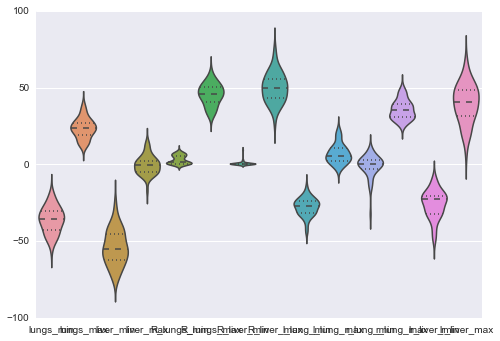

In [6]:
def get_distances(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'IUGR', 
                                'lungs_min', 'lungs_max',
                                'liver_min', 'liver_max',
                                'R_lungs_min', 'R_lungs_max',
                                'R_liver_min', 'R_liver_max',
                                'l_lung_min', 'l_lung_max',
                                'r_lung_min', 'r_lung_max',
                                'lr_liver_min', 'lr_liver_max'),
                       index=range(len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        # Image coordinates
        brain_center = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')

        heart_center = np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')
        
        left_lung = np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),
                                              dtype='float')
        
        right_lung = np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),
                                               dtype='float')

        u = brain_center - heart_center
        u /= np.linalg.norm( u )
        
        v = right_lung - left_lung
        v -= np.dot(v,u)*u
        v /= np.linalg.norm(v)
        
        lungs_coords = np.argwhere( np.logical_or( labels == 3, labels == 4 ) )
        lungs_projection = np.dot( lungs_coords - heart_center, u )
        R_lungs = np.linalg.norm( (lungs_coords - heart_center) - lungs_projection[...,np.newaxis]*u[np.newaxis,...],
                                  axis=1 )
        
        l_lung_coords = np.argwhere( labels == 3 )
        l_lung = np.dot( l_lung_coords - heart_center, v )
        
        r_lung_coords = np.argwhere( labels == 4 )
        r_lung = np.dot( r_lung_coords - heart_center, v )
        
        liver_coords = np.argwhere( labels == 8 )
        liver_projection = np.dot( liver_coords - heart_center, u )
        R_liver = np.linalg.norm( (liver_coords - heart_center) - liver_projection[...,np.newaxis]*u[np.newaxis,...],
                                  axis=1 )
        
        lr_liver = np.dot( liver_coords - heart_center, v )
        
        res.loc[i] = [ patient_id, ga, all_iugr[patient_id][0]==1, 
                       lungs_projection.min(), lungs_projection.max(),
                       liver_projection.min(), liver_projection.max(),
                       R_lungs.min(), R_lungs.max(),
                       R_liver.min(), R_liver.max(),
                       l_lung.min(), l_lung.max(),
                       r_lung.min(), r_lung.max(),
                       lr_liver.min(), lr_liver.max()]

    return res

res = get_distances("/vol/bitbucket/kpk09/detector/data_resampled")
sns.violinplot(res,order=['lungs_min', 'lungs_max', 'liver_min', 'liver_max',
                          'R_lungs_min', 'R_lungs_max', 'R_liver_min', 'R_liver_max',
                          'l_lung_min', 'l_lung_max', 'r_lung_min', 'r_lung_max',
                          'lr_liver_min', 'lr_liver_max']);

In [10]:
res

patient_id     ga   IUGR lungs_min lungs_max liver_min  liver_max  \
0        1014  26.43   True -33.01889  16.66768 -30.94676   11.49583   
1        1104     24   True -35.52987  13.39655 -46.11561   1.514181   
2        1108  23.86   True  -18.1351  22.45475 -43.94692  -2.058587   
3        1126  26.43   True -34.08607  16.56197 -40.05666  -1.341376   
4        1148  22.28   True -29.10997  21.03918 -35.46835   6.014983   
5        1149  29.14  False -21.75148  38.01866 -66.62065  -7.317968   
6        1206     27  False -27.83484  28.98232 -53.09496   -3.94346   
7        1307  31.56   True -35.37294   26.6511 -45.60381   5.573948   
8        1585  25.43   True  -43.4126  11.27968 -55.26947   5.590727   
9        1671  37.71  False  -45.3164  22.46354 -58.80599 -0.3043343   
10       1830  24.57  False -37.20052  29.63728  -48.7243  -2.195696   
11       1861  29.29  False -55.77349  23.93318  -57.0609   4.127029   
12       1867     32  False -43.21109  24.00167  -54.4369  0.9637598   
13       1887  32.14  False -50.75053  15.23846 -57.96357   2.050615   
14       1901     28  False  -36.4714  28.58976 -53.76814   2.160664   
15       1935  27.43  False -41.67476  13.20073 -56.63436   6.440665   
16       1953     37  False -37.21853   25.5821 -56.98905  0.5290908   
17       1973  35.86  False -30.43831   35.2794 -66.00758  -5.152751   
18       2017  32.28   True -26.56132  34.16703 -54.97446  0.6923931   
19       2063  27.86  False  -43.2813  22.57649 -72.47221  -4.538091   
20       2140     32   True -32.45852  24.28812 -61.90917  -4.234049   
21       2154  29.86  False -41.06064  27.40983 -56.16658   3.656478   
22       2159  29.86  False -34.09289  15.36404 -73.48207  -10.00196   
23       2163  20.43   True -36.13973  18.50536 -39.35454   -5.61008   
24       2180  31.43  False -42.92798  22.62601 -66.73014  -5.656862   
25       2220     22   True -31.63568  20.53471 -61.32118  -3.567424   
26       2237     35   True -32.86234  28.84445 -65.77385  -7.967433   
27       2248  23.71   True -37.27729  22.10216 -37.13857  -1.390498   
28       2262     26   True -29.82092  38.54867 -40.41438   12.15098   
29       2265  26.57   True -39.32802   18.7857 -49.58235   -2.58213   
30       2283  27.57  False -27.69923  26.97575 -53.56463  -4.917499   
31       2284     27  False -24.97533  24.48752 -62.98337  -5.584988   
32       2293     28   True -33.79132  29.74624 -49.66945  0.2978531   
33       2312  29.71  False -47.95735  23.91772 -74.27323  -4.990575   
34       2313  30.28  False -48.46372  22.11405 -44.61428   12.27401   
35       2316  30.28  False -50.79452  19.96874 -65.82839  -6.859025   
36       2337  36.57   True -28.63103   33.8434 -60.02024   6.896272   
37       2350     32  False   -45.955  13.31349 -50.06344   9.193966   
38       2351  30.43  False -39.86482  27.00293   -66.803  -4.976666   
39       2379  20.86   True -29.97019  13.60172 -25.68982   15.03194   
40       2381  24.29  False -26.93103  25.19266  -58.2582  -1.926876   
41       2396  24.86   True -25.03536  21.23924 -46.20397  -8.554297   
42       2401  32.57  False -48.38966  28.81297 -44.99688   2.520448   
43       2429  27.42  False -48.04524  20.43163 -61.92649   -17.3142   
44       2438  35.86  False -47.36423  20.24294  -69.9013  -7.118007   
45       2481     28   True -35.56082  18.09904 -65.21995  -6.525492   
46       2494  25.57   True -21.06812  29.24234 -44.92064    0.12035   
47       2508  23.86  False -31.33026  23.89268 -56.75405  -3.238093   
48       2540     27  False -37.12719  24.92212 -58.67867  -6.463362   
49       2557  28.43  False -35.65721  33.51418 -74.29689  0.9083162   
50       2560  36.43  False -43.41386  25.31615  -62.6098   2.020382   
51        577  27.29   True  -21.7631  22.08785 -41.92055   2.501948   
52        596  27.14   True -37.93703  13.24797 -53.58031 -0.1077031   
53        784     24   True -31.17025  13.25249 -41.31712  0.8162719   
54        932  32.57   True -39.78911  26.1

In [2]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/heart_center/*_img.nii.gz" ))
print "total files:", len(all_files)
    
average = irtk.zeros(irtk.imread(all_files[0]).get_header())

for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32').rescale(0,1000)
    average += img
    average += img.view(np.ndarray)[:,::-1,:]
       
average /= 2*len(all_files)

irtk.imwrite("tmp/average_mirrored.nii.gz",average);

total files: 55


In [53]:
# Lung volume: left and right

def get_volumes(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'IUGR', 
                                'left_lung', 'right_lung',
                                'heart', 'liver',
                                'brain'),
                       index=range(len(all_files)),
                       dtype='float')
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        brain = np.sum(labels == 2)
        heart = np.sum(labels == 5)
        left_lung = np.sum(labels == 3)
        right_lung = np.sum(labels == 4)
        liver = np.sum(labels == 8)
        
        res.loc[i] = [ int(patient_id), ga, all_iugr[patient_id][0]==1, 
                       left_lung, right_lung,
                       heart, liver,
                       brain ]

    return res

res = get_volumes("/vol/bitbucket/kpk09/detector/data_resampled")

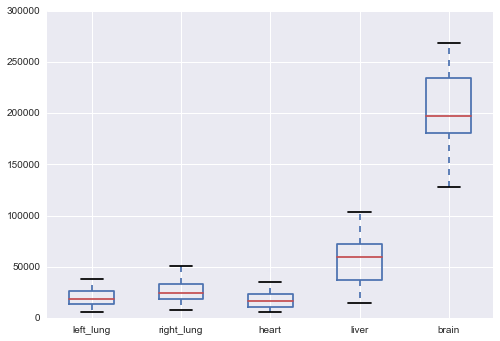

In [29]:
res[['left_lung','right_lung','heart','liver','brain']].boxplot();

Healthy: (-6.4379544917481466, 4.826031227913429e-07)
IUGR: (-7.3905287488870766, 1.2458684732536751e-07)


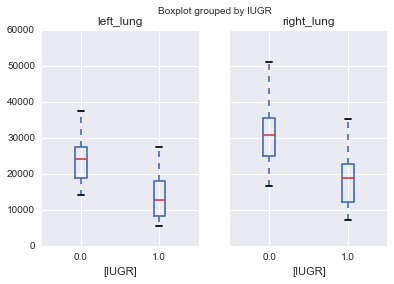

In [58]:
print "Healthy:", stats.ttest_rel(res[res['IUGR']==0]['left_lung'],res[res['IUGR']==0]['right_lung'])
print "IUGR:", stats.ttest_rel(res[res['IUGR']==1]['left_lung'],res[res['IUGR']==1]['right_lung'])
res[['left_lung','right_lung','IUGR']].boxplot(by='IUGR');

In [ ]:
# make plots in voxels (normalised images) for left and right lung volumes, healthy and iugr, and left/right ratio

In [55]:
def get_volumes(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'IUGR', 
                                'left_lung', 'right_lung',
                                'heart', 'liver',
                                'brain'),
                       index=range(len(all_files)),
                       dtype='float')
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f).resample(1.0,interpolation='nearest')
        
        brain = np.sum(labels == 2)
        heart = np.sum(labels == 5)
        left_lung = np.sum(labels == 3)
        right_lung = np.sum(labels == 4)
        liver = np.sum(labels == 8)
        
        res.loc[i] = [ int(patient_id), ga, all_iugr[patient_id][0]==1, 
                       left_lung, right_lung,
                       heart, liver,
                       brain ]

    return res

res = get_volumes("/vol/vipdata/data/fetal_data/Mellisa_Damodaram/full_body_segmentations")

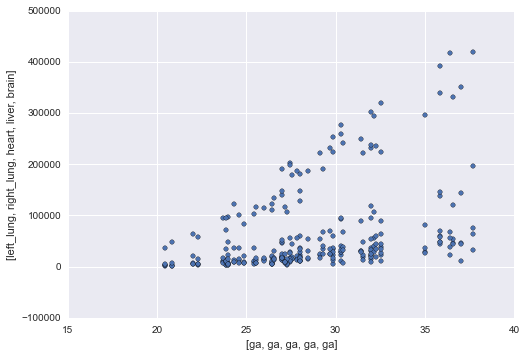

In [42]:
res[['left_lung','right_lung','heart','liver','brain','ga']].plot(x=(['ga']*5),y=['left_lung','right_lung','heart','liver','brain'],kind='scatter');

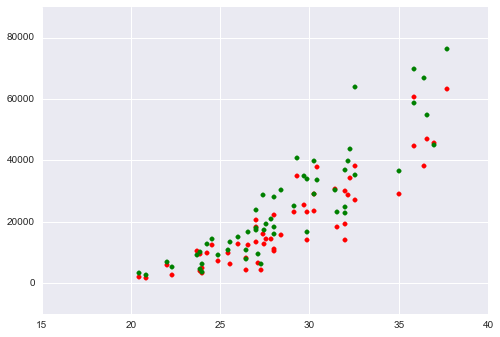

In [49]:
plt.scatter(res['ga'],res['left_lung'],marker='o',color='r')
plt.scatter(res['ga'],res['right_lung'],marker='o',color='g')

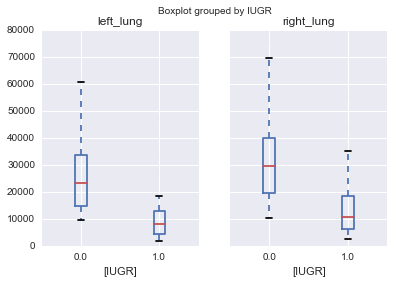

In [51]:
res[['left_lung','right_lung','IUGR']].boxplot(by='IUGR');

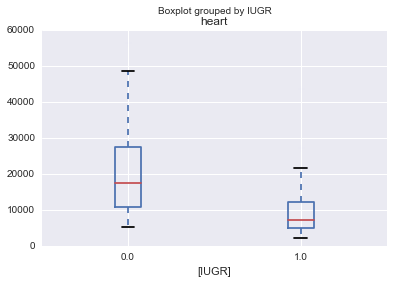

In [52]:
res[['heart','IUGR']].boxplot(by='IUGR');

0.0898751194252 0.0394237664491


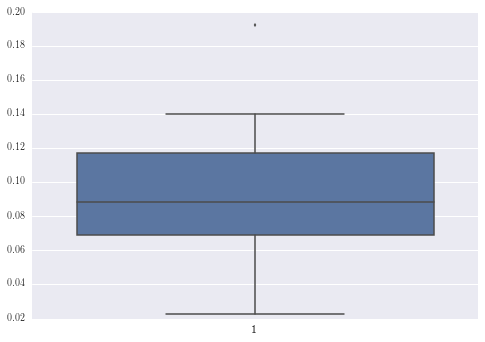

In [65]:
values = np.array(res[res['IUGR']==0]['heart']/res[res['IUGR']==0]['brain'])
print values.mean(), values.std()
sns.boxplot(values);

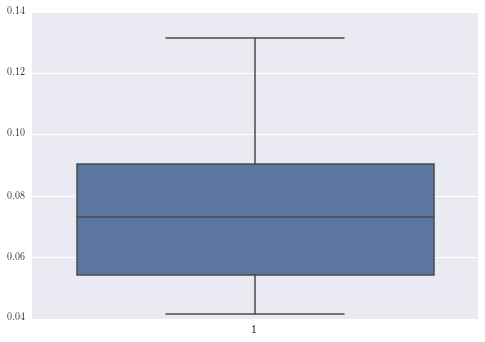

In [61]:
sns.boxplot(np.array((res[res['IUGR']==1]['heart']/res[res['IUGR']==1]['brain'])))

0.795517334411 0.138651573727


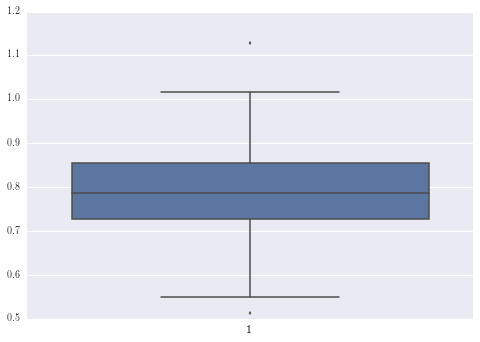

In [67]:
values = np.array(res[res['IUGR']==0]['left_lung']/res[res['IUGR']==0]['right_lung'])
print values.mean(), values.std()
sns.boxplot(values);

0.750790926322 0.142341752557


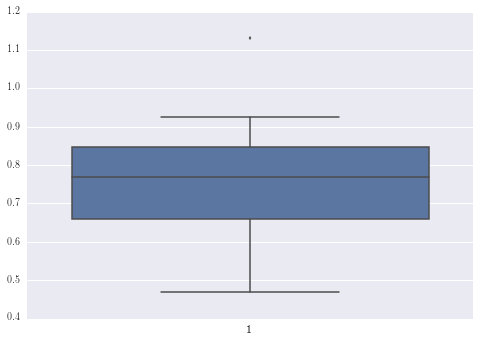

In [69]:
values = np.array(res[res['IUGR']==1]['left_lung']/res[res['IUGR']==1]['right_lung'])
print values.mean(), values.std()
sns.boxplot(values);

In [2]:
def get_R(seg):
    ZYX = np.argwhere(seg)
    ZYX -= ZYX.mean(axis=0)
    R = np.linalg.norm(ZYX,axis=1) 
    return R.mean() + 1.96*R.std()

def get_radius(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'IUGR', 
                                'left_lung', 'right_lung',
                                'heart', 'liver',
                                'brain'),
                       index=range(len(all_files)),
                       dtype='float')
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f).resample(1.0,interpolation='nearest')
        
        brain = get_R(labels == 2)
        heart = get_R(labels == 5)
        left_lung = get_R(labels == 3)
        right_lung = get_R(labels == 4)
        liver = get_R(labels == 8)
        
        res.loc[i] = [ int(patient_id), ga, all_iugr[patient_id][0]==1, 
                       left_lung, right_lung,
                       heart, liver,
                       brain ]

    return res

radius = get_radius("/vol/bitbucket/kpk09/detector/data_resampled")

In [3]:
radius[['left_lung','right_lung','heart','liver','brain']].mean()

left_lung     25.720154
right_lung    27.198737
heart         19.051234
liver         33.334482
brain         40.586013
dtype: float64

WEIGHT...
---------

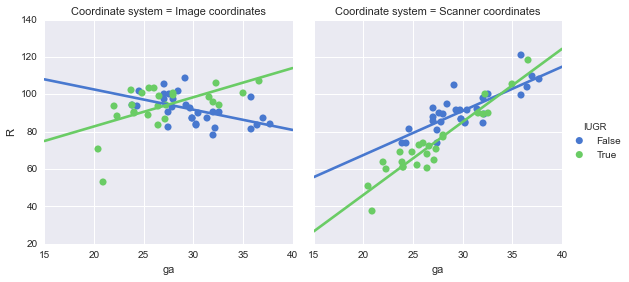

In [2]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        # Scanner coordinates
        brain_center_world = labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')[::-1])

        heart_center_world =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')[::-1])
        
        v_world = heart_center_world - brain_center_world
        R_world = np.linalg.norm(v_world)
        
        res.loc[2*i] = [patient_id, ga, R_world, all_iugr[patient_id][0]==1, 'Scanner coordinates']
        
        # Image coordinates
        brain_center = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')

        heart_center = np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')

        v = heart_center - brain_center
        R = np.linalg.norm(v)
        
        res.loc[2*i+1] = [patient_id, ga, R, all_iugr[patient_id][0]==1, 'Image coordinates']

    return res.convert_objects(convert_numeric=True)

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center_weight")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

In [8]:
res[res["Coordinate system"] == "Image coordinates"].convert_objects(convert_numeric=True)['R']#.boxplot()

1       83.482407
3       90.596802
5       94.428864
7       93.954224
9       88.250320
11     108.999680
13     105.766098
15      98.660553
17      88.721802
19      84.241241
21     102.031967
23      94.328659
25      90.503510
27      82.147217
29      97.729202
31      82.520203
33      87.223419
35      98.726685
37     106.050964
39      93.466904
41      95.900558
43      87.297150
45      87.207062
47      70.719345
49      87.230392
51      93.761124
53     100.791512
55     102.446243
57     103.459396
59      99.120781
61     100.070435
63      97.483528
65     100.765381
67      92.707764
69      83.464539
71      83.982712
73     107.325378
75      78.343307
77      90.061295
79      53.278549
81      93.685822
83     100.706703
85      90.701065
87      90.326660
89      81.500885
91      99.520287
93     103.534851
95      94.346436
97     100.119217
99     101.661743
101     83.714203
103     94.175400
105     86.646225
107     90.254898
109     94.362915
Name: R, L

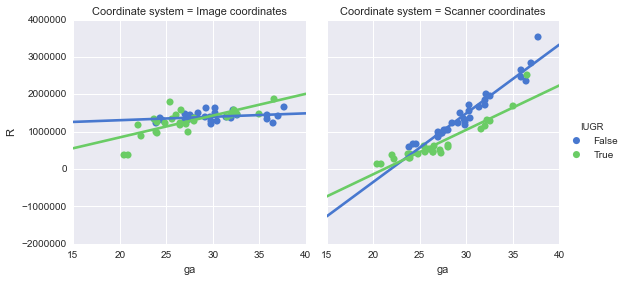

In [39]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        volume = float(np.sum(labels>0))
        res.loc[2*i] = [patient_id, ga, volume, all_iugr[patient_id][0]==1, 'Image coordinates']
        
        # Scanner coordinates
        volume_scanner = float(volume*labels.header['pixelSize'][0]*labels.header['pixelSize'][1]*labels.header['pixelSize'][2])
        
        res.loc[2*i+1] = [patient_id, ga, volume_scanner, all_iugr[patient_id][0]==1, 'Scanner coordinates']

    return res.convert_objects(convert_numeric=True)

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center_weight")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

In [40]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/heart_center_weight/*_img.nii.gz" ))
print "total files:", len(all_files)

if not os.path.exists('tmp/heart_png_weight'):
    os.makedirs('tmp/heart_png_weight')
    
header = irtk.imread(all_files[0]).get_header()
    
average = irtk.zeros(deepcopy(header))
average1 = irtk.zeros(deepcopy(header))
average2 = irtk.zeros(deepcopy(header))

header['dim'][3] = 8
proba = irtk.zeros(deepcopy(header),dtype='float32')

n1 = 0
n2 = 0
for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32').rescale(0,1000)
    irtk.imshow(img,filename="tmp/heart_png_weight/"+patient_id+".png") # index is ZYX
    average += img
    if all_iugr[patient_id][0]==1:
        average1 += img
        n1 += 1
    else:
        average2 += img
        n2 += 1
        
    seg = irtk.imread("/vol/bitbucket/kpk09/detector/heart_center_weight/"+patient_id+"_seg.nii.gz")
    for l in range(8):
        proba[l] += (seg == (l+1)).astype("float32")
        
        
print n1,n2
        
average /= len(all_files)
average1 /= n1
average2 /= n2 

proba /= len(all_files)

irtk.imwrite("tmp/average_heart_center_weight.nii.gz",average);
irtk.imwrite("tmp/average1_heart_center_weight.nii.gz",average1);
irtk.imwrite("tmp/average2_heart_center_weight.nii.gz",average2);

irtk.imwrite("tmp/proba_heart_center_weight.nii.gz",proba);

total files: 55
25 30


In [42]:
img1 = irtk.imread("tmp/average_heart_center.nii.gz")
img2 = irtk.imread("tmp/average_heart_center_weight.nii.gz")

irtk.imwrite( "tmp/average_heart_center_noheader.nii.gz", irtk.Image(img1) )
irtk.imwrite( "tmp/average_heart_center_weight_noheader.nii.gz", irtk.Image(img2) )

True

CRL IUGR
--------

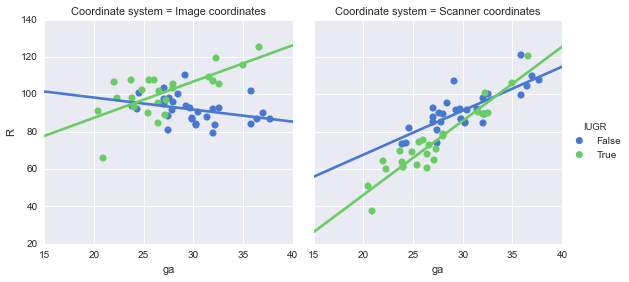

In [36]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        # Scanner coordinates
        brain_center_world = labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')[::-1])

        heart_center_world =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')[::-1])
        
        v_world = heart_center_world - brain_center_world
        R_world = np.linalg.norm(v_world)
        
        res.loc[2*i] = [patient_id, ga, R_world, all_iugr[patient_id][0]==1, 'Scanner coordinates']
        
        # Image coordinates
        brain_center = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),
                                 dtype='float32')

        heart_center = np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),
                                 dtype='float32')

        v = heart_center - brain_center
        R = np.linalg.norm(v)
        
        res.loc[2*i+1] = [patient_id, ga, R, all_iugr[patient_id][0]==1, 'Image coordinates']

    return res

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center_weight")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

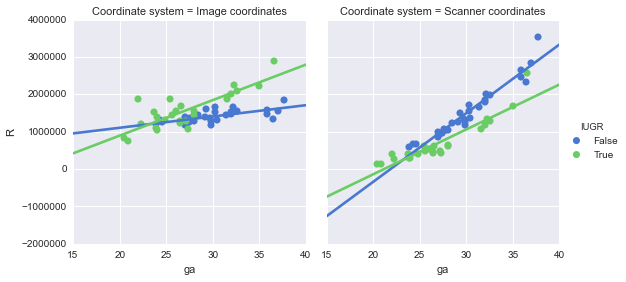

In [37]:
def get_heart_brain_distance(myfolder):
    all_files = sorted(glob( myfolder + "/*_seg.nii.gz"))
    
    folder = os.path.basename(myfolder)
    res = pd.DataFrame(columns=('patient_id', 'ga', 'R', 'IUGR', 'Coordinate system'),
                       index=range(2*len(all_files)))
    for i,f in enumerate(all_files):
        patient_id = os.path.basename(f)[:-len("_seg.nii.gz")]
        ga = all_ga[patient_id]
        labels = irtk.imread(f)
        
        volume = float(np.sum(labels>0))
        res.loc[2*i] = [patient_id, ga, volume, all_iugr[patient_id][0]==1, 'Image coordinates']
        
        # Scanner coordinates
        volume_scanner = float(volume*labels.header['pixelSize'][0]*labels.header['pixelSize'][1]*labels.header['pixelSize'][2])
        
        res.loc[2*i+1] = [patient_id, ga, volume_scanner, all_iugr[patient_id][0]==1, 'Scanner coordinates']

    return res.convert_objects(convert_numeric=True)

res = get_heart_brain_distance("/vol/bitbucket/kpk09/detector/heart_center_weight")
sns.lmplot("ga", "R", col="Coordinate system", hue="IUGR", data=res,
           col_wrap=2, ci=None, palette="muted", size=4, legend=True,
           scatter_kws={"s": 50, "alpha": 1});

Allometric growth
-----------------

```
@article{huxley1936terminology,
  title={Terminology of relative growth},
  author={Huxley, Julian S and Teissier, Georges},
  journal={Nature},
  volume={137},
  number={3471},
  pages={780--781},
  year={1936}
}
```

In [20]:
def allometric_growth(folder):
    all_files = sorted( glob( folder+"/*_seg.nii.gz" ) )
    
    all_ga = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/melissa_ga.tsv", "rb"), delimiter="\t" )
    for patient_id, ga in reader:
        all_ga[patient_id] = float(ga)
    
    all_iugr = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/iugr.tsv", "rb"), delimiter="\t" )
    skip = True
    for patient_id, iugr, iugr_severity in reader:
        if skip:
            skip = False
            continue
        all_iugr[patient_id] = int(iugr)==1
    
    res = []
    for f in all_files:
        
        patient_id = os.path.basename(f).split('_')[0]
        # if all_iugr[patient_id]:
        #     continue
            
        seg = irtk.imread(f,dtype='int32')
        ga = all_ga[patient_id]
        
        body = np.sum(seg>0)
        brain = float(np.sum(seg==2)) / body
        lungs = float(np.sum(seg==3)+np.sum(seg==4)) / body
        heart = float(np.sum(seg==5)) / body
        liver = float(np.sum(seg==8)) / body
        
        res.append( [ga,brain,heart,lungs,liver] )
        
    res = np.array(res)
        
    return pd.DataFrame( { 'GA' : res[:,0],
                           'Brain' : res[:,1]*100,
                           'Heart' : res[:,2]*100,
                           'Lungs' : res[:,3]*100,
                           'Liver' : res[:,4]*100 } ).convert_objects(convert_numeric=True)

In [8]:
data = allometric_growth("/vol/vipdata/data/fetal_data/Mellisa_Damodaram/full_body_segmentations_lcc")

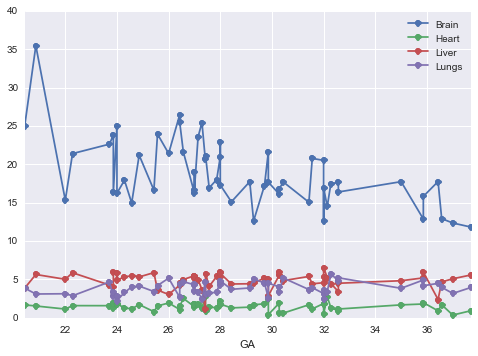

In [21]:
data = allometric_growth("/vol/bitbucket/kpk09/detector/data_resampled")
data.sort(columns='GA').plot(x='GA',marker='o')

In [19]:
data

Brain     GA      Heart      Liver      Lungs
0     100  26.43   4.075336  16.060804  10.047334
1     100  24.00   7.214054  23.289202  11.435800
2     100  23.86   5.182524  17.019623  11.777099
3     100  26.43   5.866869  17.819366  17.333165
4     100  22.28   7.410347  27.446911  13.410191
5     100  29.14   7.836458  24.999898  21.910055
6     100  27.00   8.895157  33.817923  26.496389
7     100  31.56   5.590179  21.313114  18.899756
8     100  25.43   4.785006  35.387628  20.584164
9     100  37.71   7.879578  47.289860  33.498419
10    100  24.57   7.785978  36.767680  26.828032
11    100  29.29  13.278521  35.920448  40.073707
12    100  32.00  13.830612  41.646856  28.738562
13    100  32.14  19.029902  36.166991  23.348168
14    100  28.00  10.357471  33.431169  27.820649
15    100  27.43   4.181967  27.251452  14.870722
16    100  37.00   2.876511  41.173115  25.703438
17    100  35.86  13.971528  40.390596  38.265239
18    100  32.28   7.517655  25.555317  32.741065
19    100  27.86   7.070393  29.885018  18.697499
20    100  32.00   9.067912  22.307276  15.420965
21    100  29.86   2.340516  16.192549  25.565227
22    100  29.86  11.589617  23.487068  12.056460
23    100  20.43   6.733484  15.462074  15.415804
24    100  31.43  11.286706  35.805910  24.472140
25    100  22.00   7.441739  32.746792  20.457362
26    100  35.00   9.493967  27.224836  21.674509
27    100  23.71   6.984747  18.853216  20.666132
28    100  26.00   9.033997  14.198512  24.131947
29    100  26.57  11.683059  23.058534  21.791100
30    100  27.57   8.494734  24.284548  18.808811
31    100  27.00  11.049912  32.735406  20.785401
32    100  28.00  10.523440  28.131553  22.363421
33    100  29.71  10.702516  30.023828  26.351545
34    100  30.28   4.003453  35.772913  20.214611
35    100  30.28  11.850200  34.425053  24.995447
36    100  36.57  13.162544  36.229224  30.750092
37    100  32.00   2.882646  38.579797  14.534369
38    100  30.43   3.397546  27.258252  29.348616
39    100  20.86   4.338034  15.919663   8.742524
40    100  24.29   7.175241  29.612838  18.396809
41    100  24.86   8.135178  25.128277  19.511384
42    100  32.57   6.973424  27.458277  31.796251
43    100  27.42  13.323195   5.585009  22.340034
44    100  35.86  12.487481  37.678948  26.401858
45    100  28.00   7.203788  22.971850  18.388416
46    100  25.57   6.440897  15.097174  17.524677
47    100  23.86  11.838243  36.868821  20.618184
48    100  27.00   9.287809  27.252152  23.471146
49    100  28.43   8.524656  29.139652  24.577070
50    100  36.43   5.137875  13.426701  25.284205
51    100  27.29   4.998605  14.492885   9.822824
52    100  27.14   7.838321  21.023343  14.034780
53    100  24.00  11.213936  30.387788  13.793318
54    100  32.57   5.177271  19.378995  27.253747

In [3]:
all_files = sorted(glob( "/vol/bitbucket/kpk09/detector/heart_center2/*_img.nii.gz" ))
print "total files:", len(all_files)

if not os.path.exists('tmp/heart_png2'):
    os.makedirs('tmp/heart_png2')
    
header = irtk.imread(all_files[0],force_neurological=False).get_header()
    
average = irtk.zeros(deepcopy(header))
average1 = irtk.zeros(deepcopy(header))
average2 = irtk.zeros(deepcopy(header))

header['dim'][3] = 8
proba = irtk.zeros(deepcopy(header),dtype='float32')

all_data = []

n1 = 0
n2 = 0
for f in all_files:
    patient_id = os.path.basename(f)[:-len("_img.nii.gz")]
    img = irtk.imread(f,dtype='float32',force_neurological=False).rescale(0,1000)
    irtk.imshow(img,filename="tmp/heart_png2/"+patient_id+".png") # index is ZYX
    average += img
    if all_iugr[patient_id][0]==1:
        average1 += img
        n1 += 1
    else:
        average2 += img
        all_data.append(img)
        n2 += 1
        
    seg = irtk.imread("/vol/bitbucket/kpk09/detector/heart_center2/"+patient_id+"_seg.nii.gz",force_neurological=False)
    for l in range(8):
        proba[l] += (seg == (l+1)).astype("float32")
        
        
print n1,n2
        
average /= len(all_files)
average1 /= n1
average2 /= n2 

proba /= len(all_files)

irtk.imwrite("tmp/new_average_heart_center.nii.gz",average);
irtk.imwrite("tmp/new_average1_heart_center.nii.gz",average1);
irtk.imwrite("tmp/new_average2_heart_center.nii.gz",average2);

irtk.imwrite("tmp/new_proba_heart_center.nii.gz",proba);

all_data = np.array(all_data)
median = irtk.Image( np.median(all_data,axis=0), average.get_header() )
irtk.imwrite("tmp/new_median2_heart_center.nii.gz",median);

total files: 55
25 30


In [6]:
all_files = sorted(glob( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/full_body_segmentations/*" ))
all_files = filter( lambda x: '_' not in os.path.basename(x), all_files )
print "total files:", len(all_files)

if not os.path.exists('tmp/healthy_png'):
    os.makedirs('tmp/healthy_png')
    
if not os.path.exists('tmp/iugr_png'):
    os.makedirs('tmp/iugr_png')
    
for f in all_files:
    patient_id = os.path.basename(f).split('.')[0]
    img = irtk.imread(f,dtype='float32').saturate(0.1,99.9).rescale().astype('uint8')
    
    if all_iugr[patient_id][0]==1:
        irtk.imwrite("tmp/iugr_png/"+patient_id+".png", img[img.shape[0]/2])
    else:
        irtk.imwrite("tmp/healthy_png/"+patient_id+".png", img[img.shape[0]/2])

total files: 56


AttributeError: 'NoneType' object has no attribute 'saturate'

In [7]:
ozan_folder = "/vol/bitbucket/oo2113/mylandmarks"
all_files = glob(ozan_folder+"/*.vtk")

ground_truth_folder = "/vol/vipdata/data/fetal_data/motion_correction/landmarks"
img_folder = "/vol/vipdata/data/fetal_data/motion_correction/original_scans"

data = []
for f in all_files:
    p = irtk.read_points(f)
    name = os.path.basename(f)[:-len(".vtk")]
    
    if name in ['2116_3','1953_2']:
        # left and right lungs have been inverted
        tmp = p.copy()
        p[4] = tmp[3]
        p[3] = tmp[4]

    ground_truth_file = ground_truth_folder+"/" + name + '_landmarks.nii.gz'
    labels = irtk.imread( ground_truth_file )
    
    # ground truth
    center_left_lung = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 1).view(np.ndarray) ),dtype='float32')[::-1])
    center_right_lung = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),dtype='float32')[::-1])
    center_heart = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),dtype='float32')[::-1])
    center_liver = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')[::-1])
    center_brain = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),dtype='float32')[::-1])
   
    # Ozan
    ozan_left_lung = p[4]
    ozan_right_lung = p[3]
    ozan_heart = p[2]
    ozan_liver = p[1]
    ozan_brain = p[0]
    
    data.append(map( np.linalg.norm, [center_left_lung - ozan_left_lung,
                                center_right_lung - ozan_right_lung,
                                center_heart - ozan_heart,
                                center_liver - ozan_liver,
                                center_brain - ozan_brain] ))
    print name, data[-1]
    

data = np.array(data)
print data.mean(axis=0)
print data.std(axis=0)

1953_4 [8.2109039872340652, 3.1554878310779451, 3.9001057046399912, 14.757662236318851, 9.5699819638378081]
1973_10 [10.482639966179853, 7.2259881593856923, 8.1185180880951346, 7.5855108402022324, 11.421620402154785]
2116_3 [4.7274597431347489, 5.1104265628025551, 8.3180628614062364, 0.9131401239811191, 5.5088596567081609]
2116_4 [6.0437876222711573, 16.522732181164308, 3.1912850539202449, 9.3196980992415579, 6.9022411866674691]
1347_1 [10.839192849007361, 11.422670214408896, 7.8320063265115722, 2.7998810885368366, 7.2410710387795403]
2339_1 [7.7965184776585996, 2.6924602303274892, 4.3227016596795327, 5.4704576279866082, 11.647989579899498]
1934_1 [6.2962292141019383, 4.8809101821678862, 5.4671955334751834, 4.9923925914477714, 14.052203183851013]
2324_5 [2.5679613633387688, 4.0639657274190677, 3.4856143986377535, 6.1917094838600857, 2.3946100827248169]
2206_2 [4.4399325389239639, 6.0391919337768503, 8.4682820659661679, 8.8245932992433929, 11.496808139147607]
1351_8 [6.0774721449741778,